In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import bloscpack as bp

import sys
import os
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from data_manager import *
from metadata import *

from annotation_utilities import *

from itertools import izip
import pandas as pd

import time

import matplotlib.pyplot as plt
%matplotlib inline

from vis3d_utilities import *

Setting environment for Local Macbook Pro


In [425]:
# with open('colors.txt', 'r') as f:
#     colors = {l[0]: np.r_[float(l[1]), float(l[2]), float(l[3])] for l in map(lambda x: x.split(), f.readlines())}

In [4]:
stack = 'MD589'

In [6]:
detector_id = 15

In [504]:
shell_polydata = DataManager.load_shell_mesh(stack=stack, downscale=32, return_polydata_only=True)
shell_actor = actor_mesh(shell_polydata, (1,1,1), opacity=.3, wireframe=False)

# Show score volume

In [514]:
score_show_limit = 0.85
outside_roi_opacity = 0.01
in_roi_opacity = 0.1

# for structure_u in all_known_structures:
for structure_u in ['5N']:

    vol = DataManager.load_original_volume(stack=stack, structure=structure_u,
                                           prep_id=2, detector_id=detector_id, downscale=32)

    scvol_bbox_rel2uncropped = \
    DataManager.load_original_volume_bbox(stack=stack, volume_type='score', 
                                          structure=structure_u, 
                                          prep_id=2, detector_id=detector_id, downscale=32,
                                         relative_to_uncropped=True)

    annvols, _, _ = DataManager.load_original_volume_all_known_structures(stack=stack, structures= structure_u if structure_u in singular_structures else [convert_to_left_name(structure_u), convert_to_right_name(structure_u)], 
                                                                          downscale=32, 
                                     volume_type='annotationAsScore')
    annvol_bbox_rel2uncropped = DataManager.load_original_volume_bbox(stack=stack, structure='7n_R', downscale=32, 
                                     volume_type='annotationAsScore')


    toshow_xyzs_rel2sc = np.array(np.nonzero(vol > score_show_limit))[[1,0,2]].T # these are shown with lower opacity

    vol_opacity = np.zeros(vol.shape, np.float32)
    for x_rel2sc, y_rel2sc, z_rel2sc in toshow_xyzs_rel2sc:

        vol_opacity[y_rel2sc, x_rel2sc, z_rel2sc] = outside_roi_opacity

        xyz_rel2ann = (x_rel2sc, y_rel2sc, z_rel2sc) + scvol_bbox_rel2uncropped[[0,2,4]] - annvol_bbox_rel2uncropped[[0,2,4]]
        for annvol in annvols.itervalues():
            if all(xyz_rel2ann > 0) and \
            xyz_rel2ann[0] < annvol.shape[1] and \
            xyz_rel2ann[1] < annvol.shape[0] and \
            xyz_rel2ann[2] < annvol.shape[2] and \
            annvol[xyz_rel2ann[1], xyz_rel2ann[0], xyz_rel2ann[2]] > 0:
                vol_opacity[y_rel2sc, x_rel2sc, z_rel2sc] = in_roi_opacity


    launch_vtk([shell_actor, 
#                 actor_sphere((-40,0,-60), radius=10, color=(0,1,0)),
#                 actor_sphere((0,0,0), radius=10, color=(1,0,0)),
                actor_volume(vol.astype(np.float32), 'score', 
                                          origin=scvol_bbox_rel2uncropped[[0,2,4]],
                                         auxdata=vol_opacity,
                                          c=(0,0,0)
                                         )], 
               view_up=(.3,-1,0),
               position=(-4,-3,-6),
               focal=(0,0,0),
               background_color=(1,1,1),
#                interactive=True, 
                interactive=False,
               snapshot_fn='/home/yuncong/CSHL_scorevolume_viz/%s.png' % structure_u,
#                axes=True,
               axes=False
              )

Prior structure/index map not found. Generating a new one.
Volume shape: (348, 421, 376)


In [6]:
# load in annotation space
vertices, faces = load_mesh_stl(mesh_rootdir + "/%(stack)s/%(stack)s_%(name)s_gaussianSmoothed.stl" % \
                                {'stack': stack, 'name': 'outerContour'})

In [7]:
ann_xmin, ann_xmax, ann_ymin, ann_ymax, ann_zmin, ann_zmax = \
np.loadtxt(volume_dir + '%(stack)s/volume_%(stack)s_annotation_withOuterContour_limits.txt' % {'stack': stack}, dtype=np.int)

sco_xmin, sco_xmax, sco_ymin, sco_ymax, sco_zmin, sco_zmax = \
np.loadtxt(volume_dir + '%(stack)s/%(stack)s_scoreVolume_limits.txt' % {'stack': stack}, dtype=np.int)

In [8]:
# convert to score volume space
vertices_alignedToScoreVolume = vertices + (ann_xmin,ann_ymin,ann_zmin) - (sco_xmin,sco_ymin,sco_zmin)

In [9]:
polydata_outerContour = mesh_to_polydata(vertices_alignedToScoreVolume, faces)

fill point array: 0.02 seconds
fill cell array: 0.00 seconds


In [10]:
contour_mapper = vtk.vtkPolyDataMapper()
contour_mapper.SetInputData(polydata_outerContour)

contour_actor = vtk.vtkActor()
contour_actor.SetMapper(contour_mapper)
#     a.GetProperty().SetRepresentationToWireframe()
contour_actor.GetProperty().SetColor(1,1,1)
contour_actor.GetProperty().SetOpacity(.1)

In [6]:
# Show score volumes

In [5]:
paired_structures = ['5N', '6N', '7N', '7n', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', 'SNC', 'SNR', '3N', '4N',
                    'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']
structures = paired_structures + singular_structures

In [6]:
create_if_not_exists(VOLUME_ROOTDIR + "/%(stack)s/scoreVolume_screenshots" % {'stack':stack})

'/home/yuncong/CSHL_volumes2//MD603/scoreVolume_screenshots'

In [12]:
for name_u in structures:
    launch_vtk([actor_volume(DataManager.load_score_volume(stack, name_u, 32, train_sample_scheme=1).astype(np.float32), 'score')], 
               interactive=False,
               snapshot_fn=VOLUME_ROOTDIR + "/%(stack)s/scoreVolume_screenshots/%(stack)s_scoreVolume_%(name)s.png" % \
                           {'stack':stack, 'name':name_u})

In [18]:
for name_u in labels_unsided:
    launch_vtk([contour_actor, actor_volume(load_score_volume(stack, name_u), 'score')], 
               interactive=False,
               snapshot_fn=volume_dir + "/%(stack)s/scoreVolume_screenshots/%(stack)s_scoreVolume_%(name)s.png" % \
                           {'stack':stack, 'name':name_u})

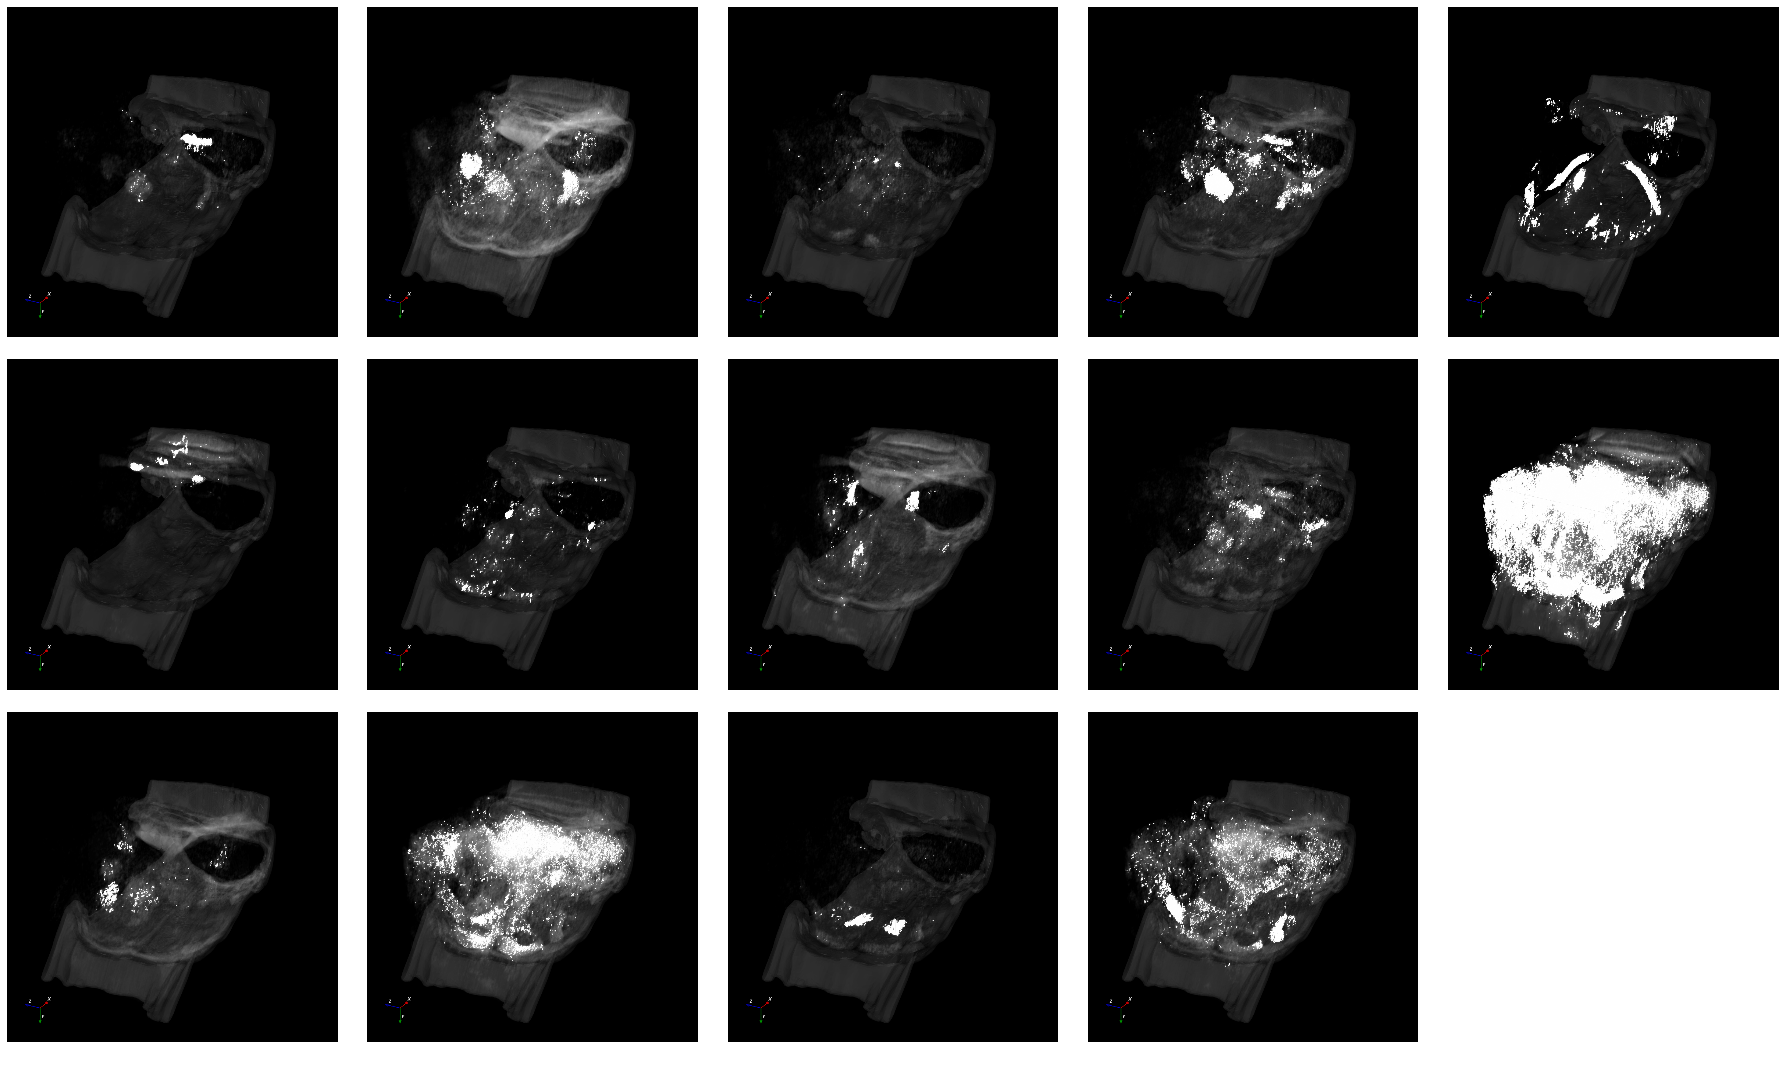

In [22]:
labels = [n for n in labels_unsided if n != 'outerContour' and n != 'sp5']
vizs = [imread((volume_dir + "/%(stack)s/scoreVolume_screenshots/%(stack)s_scoreVolume_%(name)s.png" % \
                           {'stack':stack, 'name':name})) for name in labels]
display_images_in_grids(vizs, 5)

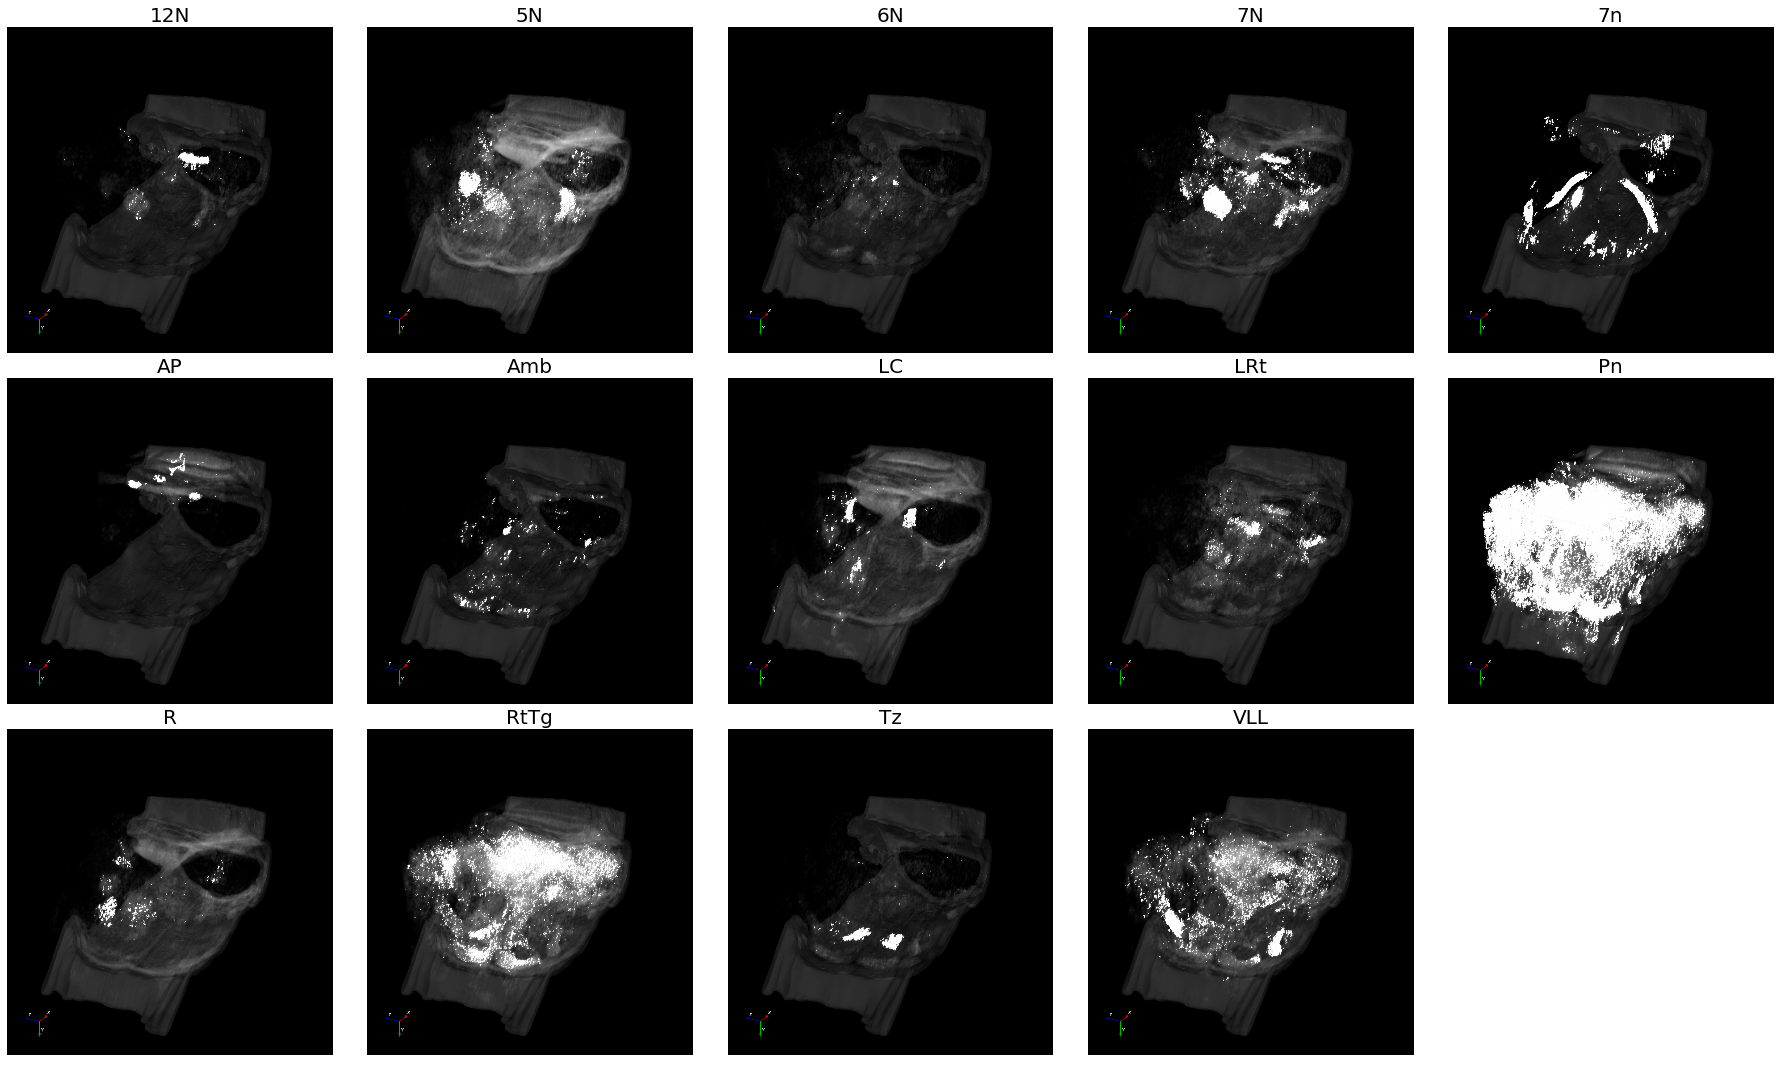

In [19]:
labels = [n for n in labels_unsided if n != 'outerContour' and n != 'sp5']
vizs = [imread((volume_dir + "/%(stack)s/scoreVolume_screenshots/%(stack)s_scoreVolume_%(name)s.png" % \
                           {'stack':stack, 'name':name})) for name in labels]
display_images_in_grids(vizs, 5, labels)

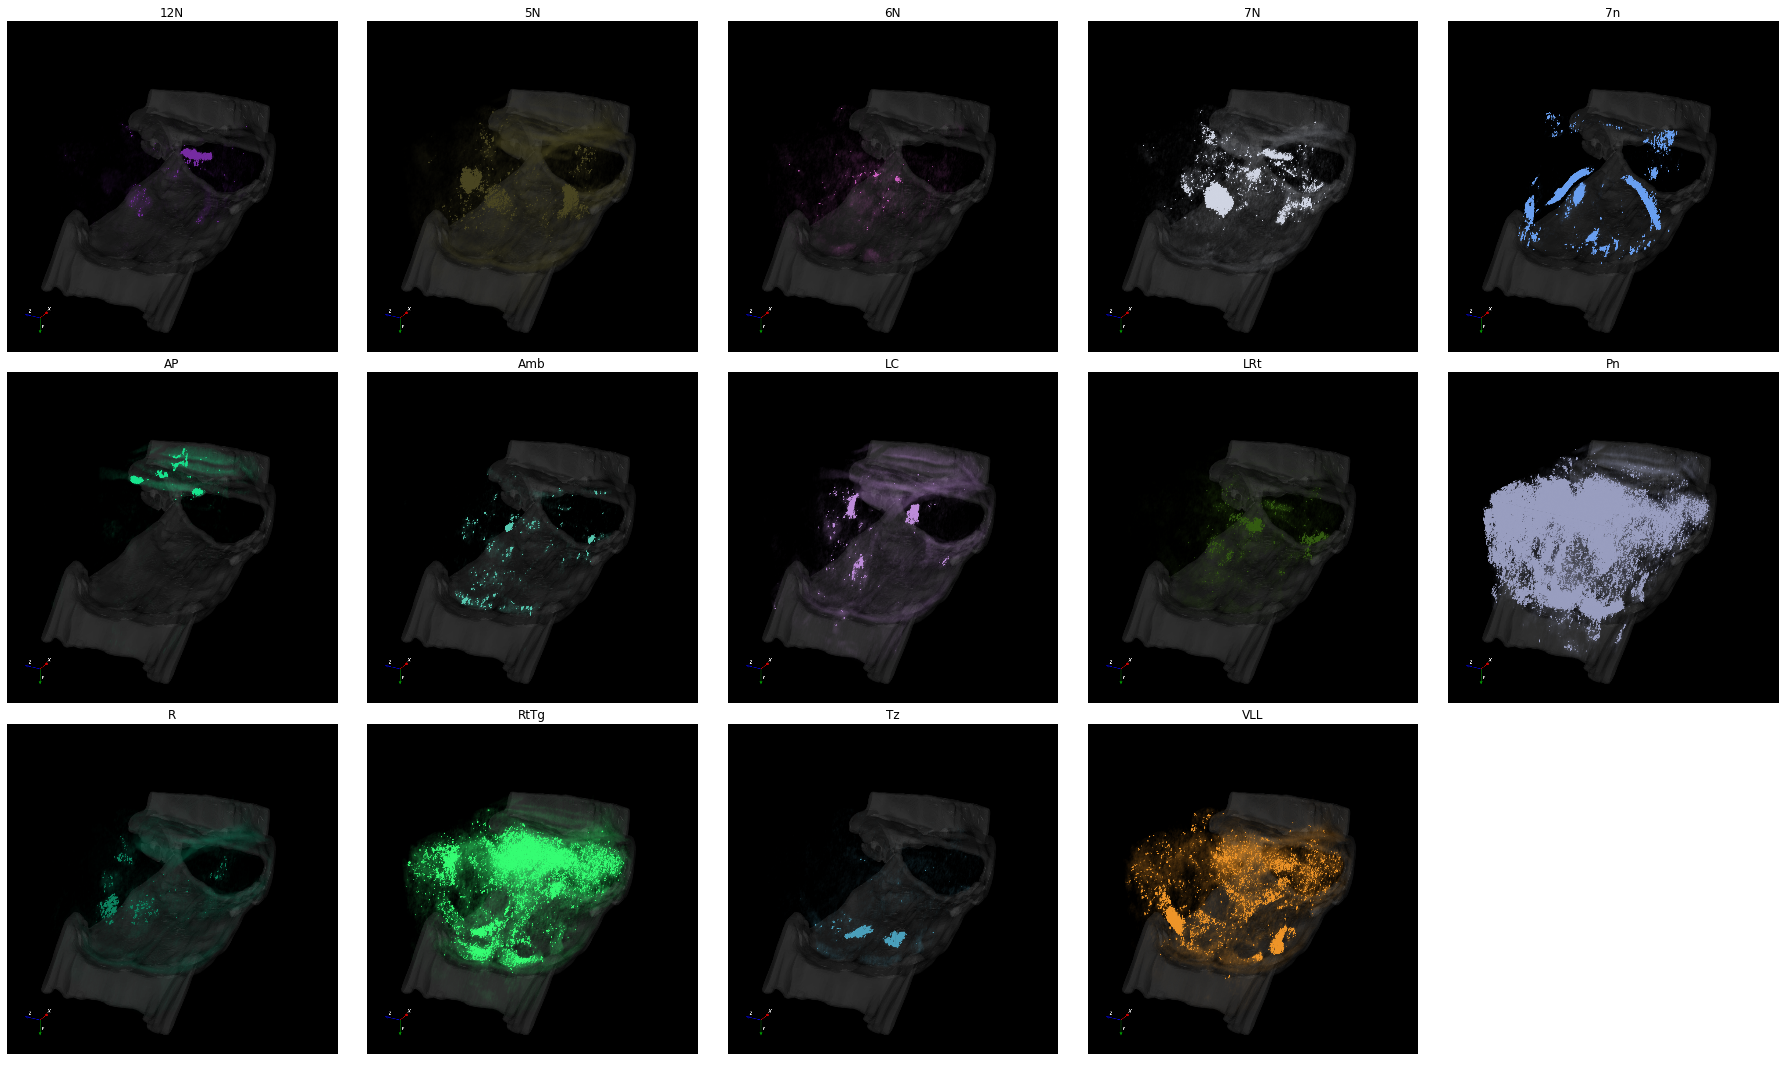

In [27]:
labels = [n for n in labels_unsided if n != 'outerContour' and n != 'sp5']
vizs = [imread((volume_dir + "/%(stack)s/scoreVolume_screenshots/%(stack)s_scoreVolume_%(name)s.png" % \
                           {'stack':stack, 'name':name})) for name in labels]
display_images_in_grids(vizs, 5, labels)